In [1]:
# %pip install -U kaleido
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import significantdigits as sd


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/ubuntu/fsl/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/fsl/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/ubuntu/fsl/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/ubuntu/fsl/lib/python3.

AttributeError: _ARRAY_API not found

In [ ]:
#Remove failed subjects
# subjects_to_remove =  ['sub-#', 'sub-##', 'sub-###']
# hcsubjects_to_remove=['sub-####', 'sub-#####']

In [ ]:
#Read data function for each threshold and removing subject failed in preprocessing

def Read_data(threshold):
    #ReadWconf data
    df=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_1.pkl')
    df1=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_2.pkl')
    df2=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_3.pkl')
    df3=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_4.pkl')
    df4=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_5.pkl')

    all_dfs = [df, df1, df2, df3, df4]
    Results_tableWConf = pd.concat(all_dfs, ignore_index=True)


    ################################################################################################

    #Read NoConf data
    dfn=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_1.pkl')
    dfn1=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_2.pkl')
    dfn2=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_3.pkl')
    dfn3=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_4.pkl')
    dfn4=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_5.pkl')

    all_dfs = [dfn, dfn1, dfn2, dfn3, dfn4]
    Results_tableNoConf = pd.concat(all_dfs, ignore_index=True)  
    #Remove failed subjects

 
    dfW = Results_tableWConf[~Results_tableWConf['subject'].isin(subjects_to_remove)]
    dfN= Results_tableNoConf[~Results_tableNoConf['subject'].isin(subjects_to_remove)]
    
    ###################################################################################################

    #Read healthy control
    dfWhc=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_hc.pkl')
    dfNhc=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_hc.pkl')
    dfWhc = dfWhc[~dfWhc['subject'].isin(hcsubjects_to_remove)]
    dfNhc= dfNhc[~dfNhc['subject'].isin(hcsubjects_to_remove)]

    return dfW,dfN,dfWhc,dfNhc


In [4]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.5)
alldfss_p=[dfN,dfNhc]
all_pop5=pd.concat(alldfss_p,ignore_index=True)

In [5]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.4)
alldfss_g=[dfN,dfNhc]
all_pop4=pd.concat(alldfss_g,ignore_index=True)

In [6]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.3)
alldfss_s=[dfN,dfNhc]
all_pop3=pd.concat(alldfss_s,ignore_index=True)

In [7]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.2)
alldfss_d=[dfN,dfNhc]
all_pop2=pd.concat(alldfss_d,ignore_index=True)

In [8]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.1)
alldfss_o=[dfN,dfNhc]
all_pop1=pd.concat(alldfss_o,ignore_index=True)

In [9]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.05)
alldfss_ps=[dfN,dfNhc]
all_pop05=pd.concat(alldfss_ps,ignore_index=True)

In [ ]:
#Compute the variance across MCA repetitions for each subject, session, and acquisition

def makestdevNum_metric(df):
    """
    Calculate standard deviation across MCA repetitions for each subject, session, and acquisition.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing network metrics for different subjects, sessions, acquisitions and repetitions
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standard deviations of metrics for each subject, session, and acquisition
    """
    # Define columns for metrics
    metric_columns = [
        'degree_(numericalVar)', 'betweeness_(numericalVar)', 
          'eigenvec_(numericalVar)',  'clusteringcoef_(numericalVar)',
        'smallworldness(numericalVar)', 'avg_shortestPathLength(numericalVar)'
    ]
    
    # Define info columns
    info_columns = ['subject', 'session', 'acquisition']
    
    # Pre-filter to exclude unwanted acquisitions for efficiency
    df_filtered = df[~df['acquisition'].isin(['acq-RLsplit1', 'acq-LRsplit1'])]
    
    # Create empty list to collect results
    results = []
    
    # Group by subject, session, acquisition to avoid nested loops
    for (subj, session, acquisition), group in df_filtered.groupby(['subject', 'session', 'acquisition']):
        # Collections for each metric across repetitions
        all_metrics = {
            'degree': [], 'betweeness': [], 'eigen': [], 
            'clustering': [], 'smallworld': [], 'shortestpath': []
        }
        
        # Collect metrics for all repetitions
        for _, row in group.iterrows():
            rep_num = row.get('repetition')
            if not isinstance(rep_num, str) or not rep_num.startswith('rep-'):
                continue
                
            # Only process if we have the necessary data
            if (isinstance(row.get('degree_centralities'), dict) and 
                isinstance(row.get('betweenness_centralities'), dict) and
                isinstance(row.get('eigenvector_centralities'), dict) and
                isinstance(row.get('clustering_coefficients'), dict)):
                
                # Extract metrics
                all_metrics['degree'].append(list(row['degree_centralities'].values()))
                all_metrics['betweeness'].append(list(row['betweenness_centralities'].values()))
                all_metrics['eigen'].append(list(row['eigenvector_centralities'].values()))
                all_metrics['clustering'].append(list(row['clustering_coefficients'].values()))
                
                # Add scalar metrics if they exist
                if 'small_worldness' in row:
                    all_metrics['smallworld'].append(row['small_worldness'])
                if 'avg_shortest_path_length' in row:
                    all_metrics['shortestpath'].append(row['avg_shortest_path_length'])
        
        # Only calculate stats if we have data
        if not all_metrics['degree']:
            continue
            
        # Calculate standard deviations
        result_row = {
            'subject': subj,
            'session': session,
            'acquisition': acquisition,
            'degree_(numericalVar)': [np.var(all_metrics['degree'], axis=0)],
            'betweeness_(numericalVar)': [np.var(all_metrics['betweeness'], axis=0)],
            'eigenvec_(numericalVar)': [np.var(all_metrics['eigen'], axis=0)],
            'clusteringcoef_(numericalVar)': [np.var(all_metrics['clustering'], axis=0)]
        }
        
        # Add scalar metrics if available
        if all_metrics['smallworld']:
            result_row['smallworldness(numericalVar)'] = np.var(all_metrics['smallworld'], axis=0)
        if all_metrics['shortestpath']:
            result_row['avg_shortestPathLength(numericalVar)'] = np.var(all_metrics['shortestpath'], axis=0)
            
        results.append(result_row)
    
    # Create DataFrame from results
    avrofStd_WithinSubject = pd.DataFrame(results)
    
    # Ensure proper data types for object columns
    for col in metric_columns:
        if col in avrofStd_WithinSubject.columns:
            avrofStd_WithinSubject[col] = avrofStd_WithinSubject[col].astype('object')
    
    return avrofStd_WithinSubject

In [ ]:
#Compute the variance across subjects for each repetition, session, and acquisition

def makestedvAnat_metric(df):
    """
    Calculate standard deviation of network metrics across subjects for each repetition, session, and acquisition.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing network metrics for different subjects, sessions, acquisitions and repetitions
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standard deviations of metrics for each repetition, session, and acquisition
    """
    # Define columns for metrics
    metric_columns = [
        'degree_(AnatomicalVar)', 'betweeness_(AnatomicalVar)', 
         'eigenvec_(AnatomicalVar)', 'clusteringcoef_(AnatomicalVar)', 
        'smallworldness(AnatomicalVar)', 'avg_shortestPathLength(AnatomicalVar)'
    ]
    
    # Info columns
    info_columns = ['iteration', 'session', 'acquisition']
    
    # Pre-filter to exclude unwanted acquisitions for efficiency
    df_filtered = df[~df['acquisition'].isin(['acq-RLsplit1', 'acq-LRsplit1'])]
    
    # Create empty list to collect results
    results = []
    
    # First loop through repetitions (since we want to group by repetition)
    for rep in range(1, 11):
        rep_str = f'rep-{rep}'
        # Filter for current repetition
        rep_df = df_filtered[df_filtered['repetition'] == rep_str]
        
        if rep_df.empty:
            continue
            
        # Group by session and acquisition
        for (session, acquisition), group in rep_df.groupby(['session', 'acquisition']):
            # Collections for metrics across subjects
            all_metrics = {
                'degree': [], 'betweeness': [], 'eigen': [], 
                'clustering': [], 'smallworld': [], 'shortestpath': []
            }
            
            # Loop through subjects in this group
            for subject, subject_data in group.groupby('subject'):
                if subject_data.empty:
                    continue
                    
                # Get the first (and should be only) row for this subject in this repetition/session/acquisition
                row = subject_data.iloc[0]
                
                # Check if required data exists
                if (isinstance(row.get('degree_centralities'), dict) and 
                    isinstance(row.get('betweenness_centralities'), dict) and
                    isinstance(row.get('eigenvector_centralities'), dict) and
                    isinstance(row.get('clustering_coefficients'), dict)):
                    
                    # Extract metrics
                    all_metrics['degree'].append(list(row['degree_centralities'].values()))
                    all_metrics['betweeness'].append(list(row['betweenness_centralities'].values()))
                    all_metrics['eigen'].append(list(row['eigenvector_centralities'].values()))
                    all_metrics['clustering'].append(list(row['clustering_coefficients'].values()))
                    
                    # Add scalar metrics if they exist
                    if 'small_worldness' in row:
                        all_metrics['smallworld'].append(row['small_worldness'])
                    if 'avg_shortest_path_length' in row:
                        all_metrics['shortestpath'].append(row['avg_shortest_path_length'])
            # if((session=='1') & (acquisition=='acq-RL')):
            #     print(len(all_metrics['degree']))
            # Only calculate stats if we have enough data (at least 2 subjects)
            if len(all_metrics['degree']) < 2:
                continue
            # if ((session=='1') & (acquisition=='acq-RL')):
            #     print(len(all_metrics['degree']))
            # Calculate standard deviations
            result_row = {
                'iteration': f'iter_{rep}',
                'session': session,
                'acquisition': acquisition,
                'degree_(AnatomicalVar)': [np.var(all_metrics['degree'], axis=0)],
                'betweeness_(AnatomicalVar)': [np.var(all_metrics['betweeness'], axis=0)],
                # Note: Fixed a bug in the original code - eigenvec and clusteringcoef were swapped
                'eigenvec_(AnatomicalVar)': [np.var(all_metrics['eigen'], axis=0)],
                'clusteringcoef_(AnatomicalVar)': [np.var(all_metrics['clustering'], axis=0)]
            }
            
            # Add scalar metrics if available
            if all_metrics['smallworld']:
                result_row['smallworldness(AnatomicalVar)'] = np.var(all_metrics['smallworld'], axis=0)
            if all_metrics['shortestpath']:
                result_row['avg_shortestPathLength(AnatomicalVar)'] = np.var(all_metrics['shortestpath'], axis=0)
                
            results.append(result_row)
    
    # Create DataFrame from results
    avrofStd_BetweenSubject = pd.DataFrame(results)
    
    # Ensure proper data types for object columns
    for col in metric_columns:
        if col in avrofStd_BetweenSubject.columns:
            avrofStd_BetweenSubject[col] = avrofStd_BetweenSubject[col].astype('object')
    
    return avrofStd_BetweenSubject

In [12]:

df5_Wconf_num=makestdevNum_metric(all_pop5)
df5_Wconf_anat=makestedvAnat_metric(all_pop5)

#######################################
df4_Wconf_num=makestdevNum_metric(all_pop4)
df4_Wconf_anat=makestedvAnat_metric(all_pop4)

################################################
df3_Wconf_num=makestdevNum_metric(all_pop3)
df3_Wconf_anat=makestedvAnat_metric(all_pop3)

##########################################################
df2_Wconf_num=makestdevNum_metric(all_pop2)
df2_Wconf_anat=makestedvAnat_metric(all_pop2)

#########################################################

df1_Wconf_num=makestdevNum_metric(all_pop1)
df1_Wconf_anat=makestedvAnat_metric(all_pop1)

#######################################################################################

df05_Wconf_num=makestdevNum_metric(all_pop05)
df05_Wconf_anat=makestedvAnat_metric(all_pop05)


In [ ]:
#Compute the root square of the average of variances across MCA runs and subjects

def compute_average_anat(df_Noconf_anat, df_Wconf_anat):
    """
    Compute average network metrics for 'no confound' and 'with confound' conditions across 10 MCA runs.
    
    Parameters:
    -----------
    df_Noconf_anat : pandas.DataFrame
        DataFrame containing anatomical network metrics for 'no confound' condition
    df_Wconf_anat : pandas.DataFrame
        DataFrame containing anatomical network metrics for 'with confound' condition
        
    Returns:
    --------
    tuple of pandas.DataFrame
        Two DataFrames containing the averaged network metrics for both conditions
    """
    # Define columns to process
    metric_cols = [
        'degree_(AnatomicalVar)', 
        'betweeness_(AnatomicalVar)', 
        'eigenvec_(AnatomicalVar)', 
        'clusteringcoef_(AnatomicalVar)', 
        'smallworldness(AnatomicalVar)',
        'avg_shortestPathLength(AnatomicalVar)'
    ]
    
    # Process a single dataframe
    def process_dataframe(df, rename_cols=False):
        # Filter the dataframe
        filtered_df = df[(df['acquisition'] == 'acq-RL') & 
                         (df['session'] == '1')] #&(df['iteration'] == "iter_1")]
        # print(len(filtered_df))
        # Dictionary to store stacked data
        stacked_data = {}
        
        # Process each metric column
        for col in metric_cols:
            stacked_data[col] = np.vstack(filtered_df[col].values)
        
        # Convert to DataFrame
        stacked_df = pd.DataFrame([stacked_data])
        
        result_df = pd.DataFrame({
            col: [np.sqrt(np.mean(stacked_df.iloc[0][col], axis=0))] for col in metric_cols
        })
        
        # # Add scalar metrics directly
        # result_df['smallworldness(AnatomicalVar)'] = stacked_df['smallworldness(AnatomicalVar)']
        # result_df['avg_shortestPathLength(AnatomicalVar)'] = stacked_df['avg_shortestPathLength(AnatomicalVar)']
        # ✅ check if any NaN exists in the DataFrame
        if result_df.isnull().values.any(): 
            print("⚠️ Warning: result_df contains NaN values in some columns")
            # optionally, print which columns
            print("Columns with NaN:", result_df.columns[result_df.isnull().any()].tolist())
  
        # Rename columns if requested (for Wconf data)
        if rename_cols:
            rename_mapping = {col: col.replace('(AnatomicalVar)', '(AnatomicalVarW)') 
                             for col in result_df.columns}
            result_df = result_df.rename(columns=rename_mapping)
        
        return result_df
    
    # Process both dataframes
    avrg_Noconf_anat = process_dataframe(df_Noconf_anat, rename_cols=False)
    avrg_Wconf_anat = process_dataframe(df_Wconf_anat, rename_cols=True)
    
    return avrg_Noconf_anat, avrg_Wconf_anat


def compute_average_num(df_Noconf_num, df_Wconf_num):
    """
    Compute average numerical network metrics for 'no confidence' and 'with confidence' conditions.
    
    Parameters:
    -----------
    df_Noconf_num : pandas.DataFrame
        DataFrame containing numerical network metrics for 'no confidence' condition
    df_Wconf_num : pandas.DataFrame
        DataFrame containing numerical network metrics for 'with confidence' condition
        
    Returns:
    --------
    tuple of pandas.DataFrame
        Two DataFrames containing the averaged numerical metrics for both conditions
    """
    # Define columns to process
    metric_cols = [
        'degree_(numericalVar)', 
        'betweeness_(numericalVar)', 
        'eigenvec_(numericalVar)', 
        'clusteringcoef_(numericalVar)', 
        'smallworldness(numericalVar)',
        'avg_shortestPathLength(numericalVar)'
    ]
    
    # Process a single dataframe
    def process_dataframe(df, rename_cols=False):
        # Filter the dataframe
        filtered_df = df[(df['acquisition'] == 'acq-RL') & 
                         (df['session'] == '1')]
        print(len(filtered_df))
        # Dictionary to store stacked data
        stacked_data = {}
        
        # Process each metric column
        for col in metric_cols:
            stacked_data[col] = np.vstack(filtered_df[col].values)
        
        # Convert to DataFrame
        stacked_df = pd.DataFrame([stacked_data])
        

        
        result_df = pd.DataFrame({
            col: [np.sqrt(np.mean(stacked_df.iloc[0][col], axis=0))] for col in metric_cols
        })
                # ✅ check if any NaN exists in the DataFrame
        if result_df.isnull().values.any(): 
            print("⚠️ Warning: result_df contains NaN values in some columns")
            # optionally, print which columns
            print("Columns with NaN:", result_df.columns[result_df.isnull().any()].tolist())
        # # Add scalar metrics directly
        # result_df['smallworldness(numericalVar)'] = stacked_df['smallworldness(numericalVar)']
        # result_df['avg_shortestPathLength(numericalVar)'] = stacked_df['avg_shortestPathLength(numericalVar)']
        
        # Rename columns if requested (for Wconf data)
        if rename_cols:
            rename_mapping = {col: col.replace('(numericalVar)', '(numericalVarW)') 
                             for col in result_df.columns}
            result_df = result_df.rename(columns=rename_mapping)
        
        return result_df
    
    # Process both dataframes
    avrg_Noconf_num = process_dataframe(df_Noconf_num, rename_cols=False)
    avrg_Wconf_num = process_dataframe(df_Wconf_num, rename_cols=True)
    
    return avrg_Noconf_num, avrg_Wconf_num


<!-- Standard deviation across MCA runs (for each subject, region, and metric):

$$
\sigma_{s,r,m} = \mathrm{StdDev}(X_{s,r,m,1}, X_{s,r,m,2}, \ldots, X_{s,r,m,10})
$$

Average standard deviation across subjects (per region and metric):

$$
\overline{\sigma}_{r, m} = \frac{1}{S} \sum_{s=1}^{S} \sigma_{s, r, m}
$$
Standard deviation across subjects (for each MCA iteration, region, and metric):

$$\sigma_{r,m,iter} = \mathrm{StdDev}(X_{1,r,m,iter}, X_{2,r,m,iter}, \ldots, X_{s,r,m,iter})$$

Average standard deviation across MCA iteration (per region and metric):

$$\overline{\sigma}_{r, m} = \frac{1}{10} \sum_{iter=1}^{10} \sigma_{ r, m,iter}$$

$$s \in \{Subjects\} , r \in \{Regions\}, m \in \{ Metrics \}, iter \in \{1,...,10\} $$ -->

In [14]:

_, avrg1_Wconf_num = compute_average_num(df1_Wconf_num, df1_Wconf_num)
_, avrg1_Wconf_anat = compute_average_anat(df1_Wconf_anat, df1_Wconf_anat)



_, avrg2_Wconf_num = compute_average_num(df2_Wconf_num, df2_Wconf_num)
_, avrg2_Wconf_anat = compute_average_anat(df2_Wconf_anat, df2_Wconf_anat)


_, avrg3_Wconf_num = compute_average_num(df3_Wconf_num, df3_Wconf_num)
_, avrg3_Wconf_anat = compute_average_anat(df3_Wconf_anat, df3_Wconf_anat)



_, avrg4_Wconf_num = compute_average_num(df4_Wconf_num, df4_Wconf_num)
_, avrg4_Wconf_anat = compute_average_anat(df4_Wconf_anat, df4_Wconf_anat)



_, avrg5_Wconf_num = compute_average_num(df5_Wconf_num, df5_Wconf_num)
_, avrg5_Wconf_anat = compute_average_anat(df5_Wconf_anat, df5_Wconf_anat)



_, avrg05_Wconf_num = compute_average_num(df05_Wconf_num, df05_Wconf_num)
_, avrg05_Wconf_anat = compute_average_anat(df05_Wconf_anat, df05_Wconf_anat)





173
173
163
163
160
160
157
157
138
138
181
181


In [15]:
from nilearn import datasets

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_labels = atlas.labels[1:]
atlas_filename=atlas.maps
# atlas_labels[0:51]

[fetch_atlas_schaefer_2018] Dataset found in /home/ubuntu/nilearn_data/schaefer_2018

In [ ]:
#Compute the NPVR for global metrics

def cmput_ratio_g(df, df1, N):
    import numpy as np
    import pandas as pd

    metrics = ['smallworldness', 'avg_shortestPathLength']
    # numerical_data = {'subject': df['subject']}
    numerical_data = {}
    for metric in metrics:
        numerical_col = [col for col in df.columns if metric in col and 'numericalVar' in col]
        anatomical1_col = [col for col in df1.columns if metric in col and 'AnatomicalVar' in col]

        if numerical_col and anatomical1_col :
            numerical_col = numerical_col[0]
            anatomical_col1 = anatomical1_col[0]

            a = df1[anatomical_col1].values[0]  # make sure this is a scalar
            # n=(df[numerical_col])
            n=(df[numerical_col]).values[0]
            ratio_values =((n) / (a)) if a != 0 else print('zero') #(2/np.sqrt(N)) *
            numerical_data[f'ratio_{metric}'] = ratio_values
        else:
            print(f"Warning: Could not find matching columns for {metric}")

    result_df = pd.DataFrame(numerical_data)
    return result_df


In [ ]:
#Compute the NPVR for local metrics

def cmput_ratio(df,df1,N):
    import pandas as pd
    import numpy as np

    # Dictionary to hold column: list_of_ratios
    ratio_data = {}

    # List of metric keywords to match columns
    metrics = ['degree', 'betweeness', 'eigenvec', 'clusteringcoef']

    for metric in metrics:
        # Get the matching column names
        num_col = [col for col in df.columns if metric in col][0]
        anat1_col = [col for col in df1.columns if metric in col][0]
        # Extract the values (lists of 100 values)
        num_vals = df[num_col].iloc[0]
        anat_vals = df1[anat1_col].iloc[0]
        # N1 = 147-8
        # N2 = 34  # assuming equal sizes

        # Flatten if nested in [[x]]
        if isinstance(num_vals[0], list):
            num_vals = [v[0] for v in num_vals]
            anat_vals = [v[0] for v in anat_vals]
            # print('num_vals=', num_vals)
        # Compute σ_pool for each pair and then n / σ_pool
        pooled_ratios = []
        for n, a in zip(num_vals, anat_vals):
            ratio =(  ((n) / (a)) )if a != 0 else print('zero') #(2/np.sqrt(N)) *
            # print("n,a,b",n,a,b)
            pooled_ratios.append(ratio)

        # Store as a single list under one row
        ratio_data[metric + '_ratio'] = [pooled_ratios]

    # Convert to single-row DataFrame
    ratio_df = pd.DataFrame(ratio_data)

    return ratio_df


<!-- $$
\bar{\sigma}(\text{d}) = \frac{\bar{\sigma}(\text{num})}{\bar{\sigma}_{pool}}
$$ -->


<!-- Variance across MCA runs (for each subject, region, and metric):

$$
Var_{s,r,m} = \mathrm{Var}(X_{s,r,m,1}, X_{s,r,m,2}, \ldots, X_{s,r,m,10})
$$

Average Variance across subjects (per region and metric):

$$
\overline{Var}_{r, m} = \frac{1}{S} \sum_{s=1}^{S} Var_{s, r, m}
$$
$$
\sigma_{num} = \sqrt{\overline{Var}_{r, m}}
$$

Variance  across subjects (for each MCA iteration, region, and metric):

$$Var_{r,m,iter} = \mathrm{Var}(X_{1,r,m,iter}, X_{2,r,m,iter}, \ldots, X_{s,r,m,iter})$$

Average Variance across MCA iteration (per region and metric):

$$\overline{Var}_{r, m} = \frac{1}{10} \sum_{iter=1}^{10} Var_{ r, m,iter}$$

$$
\sigma_{pool} = \sqrt{\overline{Var}_{r, m}}
$$


$$s \in \{Subjects\} , r \in \{Regions\}, m \in \{ Metrics \}, iter \in \{1,...,10\} $$ -->

In [18]:
ratio1=cmput_ratio(avrg1_Wconf_num,avrg1_Wconf_anat,182)
ratio1G=cmput_ratio_g(avrg1_Wconf_num ,avrg1_Wconf_anat,182)

ratio2=cmput_ratio(avrg2_Wconf_num,avrg2_Wconf_anat,179)
ratio2G=cmput_ratio_g(avrg2_Wconf_num ,avrg2_Wconf_anat,179)

ratio3=cmput_ratio(avrg3_Wconf_num,avrg3_Wconf_anat,176)
ratio3G=cmput_ratio_g(avrg3_Wconf_num ,avrg3_Wconf_anat,176)

ratio4=cmput_ratio(avrg4_Wconf_num,avrg4_Wconf_anat,170)
ratio4G=cmput_ratio_g(avrg4_Wconf_num ,avrg4_Wconf_anat,170)

ratio5=cmput_ratio(avrg5_Wconf_num,avrg5_Wconf_anat,147)
ratio5G=cmput_ratio_g(avrg5_Wconf_num ,avrg5_Wconf_anat,147)

ratio05=cmput_ratio(avrg05_Wconf_num,avrg05_Wconf_anat,182)
ratio05G=cmput_ratio_g(avrg05_Wconf_num ,avrg05_Wconf_anat,182)



In [ ]:
#Compute the average NPVR for local and global metrics

avrgRatio05 = {}
avrgRatio1 = {}
avrgRatio2 = {}
avrgRatio3= {}
avrgRatio4 = {}
avrgRatio5= {}


for col in ratio1.columns:
    avrgRatio05[col]=np.mean(ratio05[col].values[0])
    avrgRatio1[col]=np.mean(ratio1[col].values[0])
    avrgRatio2[col]=np.mean(ratio2[col].values[0])
    avrgRatio3[col]=np.mean(ratio3[col].values[0])
    avrgRatio4[col]=np.mean(ratio4[col].values[0])
    avrgRatio5[col]=np.mean(ratio5[col].values[0])
   

GavrgRatio05 = {}
GavrgRatio1 = {}
GavrgRatio2 = {}
GavrgRatio3= {}
GavrgRatio4 = {}
GavrgRatio5= {}

for col in ratio1G.columns[:]:
    GavrgRatio05[col]=np.mean(list(ratio05G[col]))
    GavrgRatio1[col]=np.mean(list(ratio1G[col]))
    GavrgRatio2[col]=np.mean(list(ratio2G[col]))
    GavrgRatio3[col]=np.mean(list(ratio3G[col]))
    GavrgRatio4[col]=np.mean(list(ratio4G[col]))
    GavrgRatio5[col]=np.mean(list(ratio5G[col]))
GavrgRatio1

{'ratio_smallworldness': np.float64(0.07134667148563364),
 'ratio_avg_shortestPathLength': np.float64(0.0463190150815945)}

In [20]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Compute ratios
ratio1 = cmput_ratio(avrg1_Wconf_num, avrg1_Wconf_anat, 182)
ratio2 = cmput_ratio(avrg2_Wconf_num, avrg2_Wconf_anat, 179)
ratio3 = cmput_ratio(avrg3_Wconf_num, avrg3_Wconf_anat, 176)
ratio4 = cmput_ratio(avrg4_Wconf_num, avrg4_Wconf_anat, 170)
ratio5 = cmput_ratio(avrg5_Wconf_num, avrg5_Wconf_anat, 147)
ratio05 = cmput_ratio(avrg05_Wconf_num, avrg05_Wconf_anat, 182)


def change(arr,col):
    # Create the 'region' column with labels
    regions = [f"region_{i+1}" for i in range(len(arr))]

    # Create the DataFrame
    df = pd.DataFrame({'region': regions, f'{col}': arr})
    return df
# Dictionary mapping threshold digits -> ratio DataFrame
ratio_map = {
    "5": ratio5,
    "4": ratio4,
    "3": ratio3,
    "2": ratio2,
    "1": ratio1,
    "05": ratio05
}

# Thresholds
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]  

# Metrics
metrics = ['betweeness', 'clusteringcoef', 'eigen', 'degree']
metric_labels = ["Betweenness Centrality", "Clustering Coefficient",
                 "Eigenvector Centrality", "Degree Centrality"]

# Colors
colors = {"PD": "rgb(128, 0, 128)"}

# Subplot grid: 4 rows (metrics) × len(thresholds) cols
fig = make_subplots(
    rows=len(metrics), cols=len(thresholds),
    shared_yaxes='rows',
    subplot_titles=[f"Thr {thr}" for thr in thresholds]*len(metrics),
    vertical_spacing=0.08
)

# Loop over metrics & thresholds
for row, (metric, metric_label) in enumerate(zip(metrics, metric_labels), start=1):
    for col, thr in enumerate(thresholds, start=1):
        thre = str(thr).split(".")[1]   # e.g. 0.05 -> "05", 0.5 -> "5"
        rPD = ratio_map[thre]
        # --- Extract values for this metric ---
        pd_val = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        
        pd_valreg=change(pd_val[:],metric)
        pd_vals=pd_valreg.melt(id_vars=['region'], var_name='metric', value_name='value')
        # print(thre,metric,pd_vals)
        # Add PD box
        fig.add_trace(
            go.Box(
                y=pd_vals['value'],
                name="Sample",
                marker=dict(color=colors["PD"], size=4),
                boxpoints="all", jitter=0.3, pointpos=-0.4,
                width=0.35,
                text=pd_vals['region'],
                hovertemplate="<b>Region:</b> %{text}<br><b>Value:</b> %{y}<br><extra>PD</extra>",
                showlegend=(row==1 and col==1)  # only show legend once
            ),
            row=row, col=col
        )

    # Add row title (metric label) on y-axis
    fig.update_yaxes(title_text=metric_label, row=row, col=1)

# Layout
fig.update_layout(
    height=300*len(metrics),
    width=220*len(thresholds),
    title="Sample variability Ratio of No Confound Pipeline across different metric and absolute thresholds",
    boxmode="group"
)

fig.show()


[fetch_atlas_schaefer_2018] Dataset found in /home/ubuntu/nilearn_data/schaefer_2018

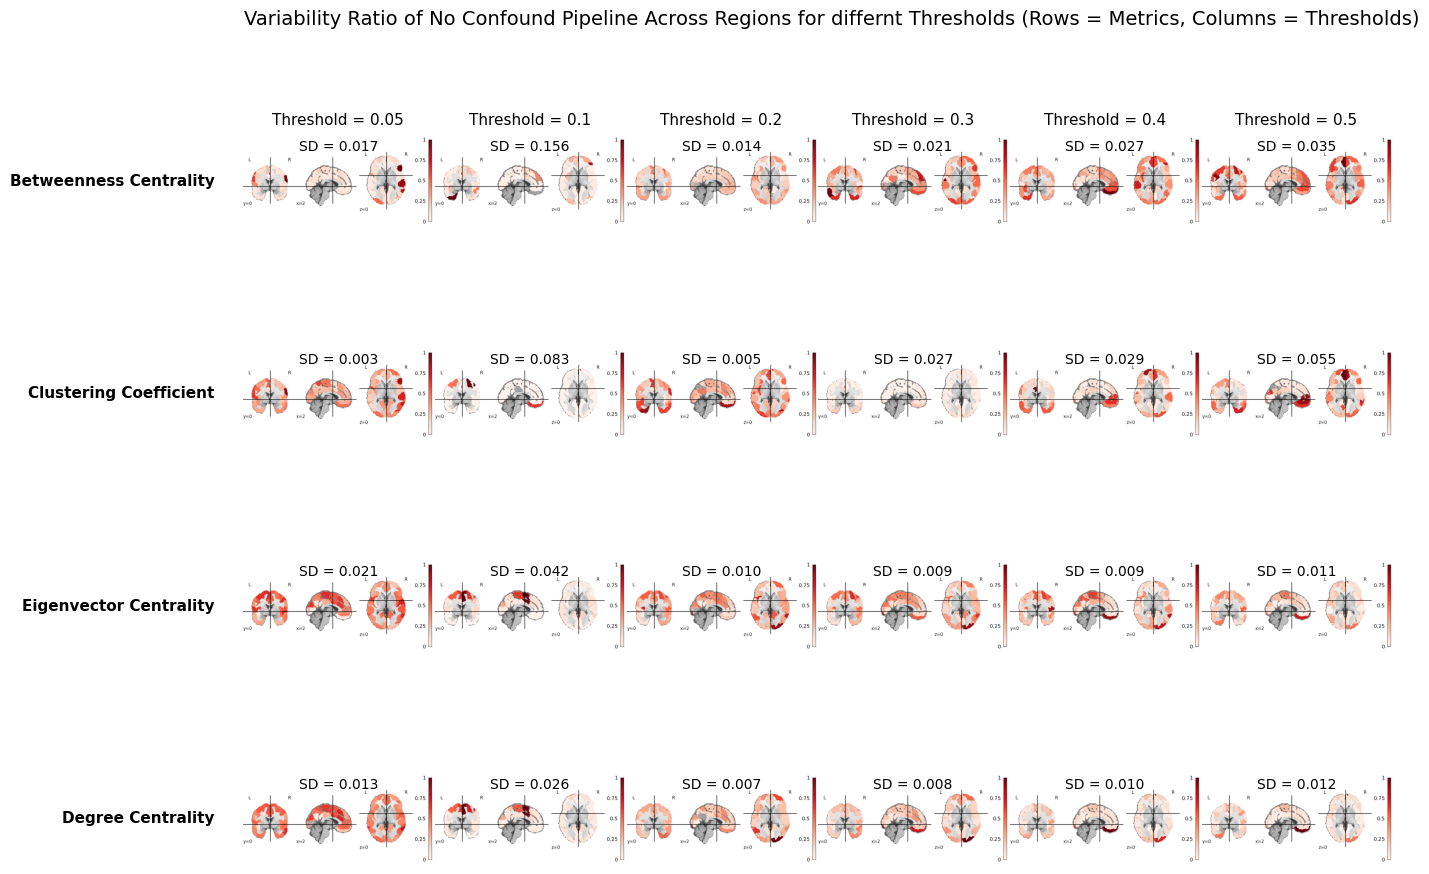

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting, datasets
import tempfile
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})
# --------------------------
# Load Schaefer Atlas (100 regions)
# --------------------------
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_filename = atlas.maps
atlas_labels = atlas.labels[1:]

# --------------------------
# Your ratio computations (already available)
# --------------------------
ratio1 = cmput_ratio(avrg1_Wconf_num, avrg1_Wconf_anat, 182)
ratio2 = cmput_ratio(avrg2_Wconf_num, avrg2_Wconf_anat, 179)
ratio3 = cmput_ratio(avrg3_Wconf_num, avrg3_Wconf_anat, 176)
ratio4 = cmput_ratio(avrg4_Wconf_num, avrg4_Wconf_anat, 170)
ratio5 = cmput_ratio(avrg5_Wconf_num, avrg5_Wconf_anat, 147)
ratio05 = cmput_ratio(avrg05_Wconf_num, avrg05_Wconf_anat, 182)

ratio_map = {
    "05": ratio05,
    "1": ratio1,
    "2": ratio2,
    "3": ratio3,
    "4": ratio4,
    "5": ratio5
}

thresholds =[0.05, 0.1, 0.2, 0.3, 0.4, 0.5] #[0.1,0.4] # [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
threshold_labels = ["0.05", "0.1", "0.2", "0.3", "0.4", "0.5"] #["0.1","0.4"] #["0.05", "0.1", "0.2", "0.3", "0.4", "0.5"]
metrics = ['betweeness', 'clusteringcoef', 'eigen', 'degree']
metric_labels = ["Betweenness Centrality", "Clustering Coefficient", "Eigenvector Centrality", "Degree Centrality"]

# --------------------------
# Compute SD table
# --------------------------
sd_table = pd.DataFrame(columns=['Threshold', 'Metric', 'Std'])

for thr in thresholds:
    thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
    rPD = ratio_map[thre]
    for i, metric in enumerate(metrics):
        vals = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        std_val = pd.Series(vals).std()
        sd_table.loc[len(sd_table)] = [thr, metric_labels[i], std_val]

# --------------------------
# Function: map ratios to brain
# --------------------------
def map_ratio_to_brain(ratio_values, atlas_filename):
    atlas_img = image.load_img(atlas_filename)
    atlas_data = atlas_img.get_fdata()
    ratio_values = np.nan_to_num(ratio_values)
    ratio_img_data = np.zeros_like(atlas_data)
    for i, val in enumerate(ratio_values, start=1):
        ratio_img_data[atlas_data == i] = val
    return image.new_img_like(atlas_img, ratio_img_data)

# --------------------------
# Temporary directory for snapshots
# --------------------------
tmpdir = tempfile.mkdtemp()

# --------------------------
# Compute global vmin/vmax for consistent colorbar
# --------------------------
# all_vals = []
# for thr in thresholds:
#     thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
#     rPD = ratio_map[thre]
#     for metric in metrics:
#         vals = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
#         all_vals.extend(vals)
# vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
# --------------------------
# Generate brain map images and store paths
# --------------------------
image_paths = {metric: [] for metric in metrics}

for metric in metrics:
    for thr in thresholds:
        thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
        rPD = ratio_map[thre]
        ratio_values = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        # ratio_img = map_ratio_to_brain(ratio_values, atlas_filename)
        vmin, vmax = 0,1 #np.nanmin(ratio_values), np.nanmax(ratio_values) #compute vmin,vmax for each metric separately or select  global vmin/vmax
        # Normalize (0–1 range)
        norm_vals = (ratio_values - np.min(ratio_values)) / (
            np.max(ratio_values) - np.min(ratio_values)
        )
        ratio_img = map_ratio_to_brain(norm_vals, atlas_filename)
        out_path = os.path.join(tmpdir, f"{metric}_thr{thre}.png")
        plotting.plot_stat_map(
            ratio_img,
            display_mode='ortho', #pick view
            cut_coords=[2,0,0],
            cmap='Reds',
            colorbar=True,
            black_bg=False,
            dim=0,
            threshold=0 ,#vmin - 10**-6,
            vmin=vmin,
            vmax=vmax,
            output_file=out_path
        )
        image_paths[metric].append(out_path)
        

# --------------------------
# Assemble figure grid (metrics as rows, thresholds as columns)
# --------------------------
n_rows = len(metrics)
n_cols = len(thresholds)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
plt.subplots_adjust(wspace=0.01, hspace=0.05, left=0.08, right=0.90, bottom=0.08, top=0.92)

for i, metric_label in enumerate(metric_labels):
    metric = metrics[i]
    for j, thr_label in enumerate(threshold_labels):
        img = plt.imread(image_paths[metric][j])
        axes[i, j].imshow(img)
        axes[i, j].axis("off")

        # Column titles: thresholds
        if i == 0:
            axes[i, j].set_title(f"Threshold = {thr_label}", fontsize=11, pad=8)

        # Row labels: metrics
        if j == 0:
            axes[i, j].text(-0.15, 0.5, metric_label,
                            transform=axes[i, j].transAxes,
                            fontsize=11, va='center', ha='right',
                            weight='bold')

        # SD annotation
        sd_value = sd_table.loc[
            (sd_table["Threshold"] == float(thr_label)) &
            (sd_table["Metric"] == metric_label),
            "Std"
        ].values[0]
        axes[i, j].text(0.5, 0.95, f"SD = {sd_value:.3f}",
                        transform=axes[i, j].transAxes,
                        ha='center', va='top', fontsize=10, color='black')

# --------------------------
# Shared colorbar
# --------------------------
# sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar.set_label("Variability Ratio", rotation=270, labelpad=15)

# --------------------------
# Figure title
# --------------------------
fig.suptitle("Variability Ratio of No Confound Pipeline Across Regions for differnt Thresholds (Rows = Metrics, Columns = Thresholds)", fontsize=14, y=0.99)
plt.show()


In [22]:
#Read With Confound data pickles
import os
import pickle
import pandas as pd

# Folder where pickles were saved
folder = "./pickles"

# File names
names_num = [f"avrg{label}_Wconf_num.pkl" for label in ["05", "1", "2", "3", "4", "5"]]
names_anat = [f"avrg{label}_Wconf_anat.pkl" for label in ["05", "1", "2", "3", "4", "5"]]
names_ratio = [f"avrgRatio{label}.pkl" for label in ["05", "1", "2", "3", "4", "5"]]
names_ratioG = [f"ratio{label}G.pkl" for label in ["05", "1", "2", "3", "4", "5"]]

# Combine them all
all_files = names_num + names_anat + names_ratio+names_ratioG

# ✅ Load everything with correct format and add "W" prefix
for name in all_files:
    path = os.path.join(folder, name)
    var_name = "W" + os.path.splitext(name)[0]  # e.g., avrg05_Wconf_num.pkl → Wavrg05_Wconf_num

    # Dictionaries are only in avrgRatio files
    if "Ratio" in name:
        with open(path, "rb") as f:
            globals()[var_name] = pickle.load(f)
    else:
        globals()[var_name] = pd.read_pickle(path)

    print(f"✅ Loaded {var_name} ({type(globals()[var_name]).__name__})")



✅ Loaded Wavrg05_Wconf_num (DataFrame)
✅ Loaded Wavrg1_Wconf_num (DataFrame)
✅ Loaded Wavrg2_Wconf_num (DataFrame)
✅ Loaded Wavrg3_Wconf_num (DataFrame)
✅ Loaded Wavrg4_Wconf_num (DataFrame)
✅ Loaded Wavrg5_Wconf_num (DataFrame)
✅ Loaded Wavrg05_Wconf_anat (DataFrame)
✅ Loaded Wavrg1_Wconf_anat (DataFrame)
✅ Loaded Wavrg2_Wconf_anat (DataFrame)
✅ Loaded Wavrg3_Wconf_anat (DataFrame)
✅ Loaded Wavrg4_Wconf_anat (DataFrame)
✅ Loaded Wavrg5_Wconf_anat (DataFrame)
✅ Loaded WavrgRatio05 (dict)
✅ Loaded WavrgRatio1 (dict)
✅ Loaded WavrgRatio2 (dict)
✅ Loaded WavrgRatio3 (dict)
✅ Loaded WavrgRatio4 (dict)
✅ Loaded WavrgRatio5 (dict)
✅ Loaded Wratio05G (DataFrame)
✅ Loaded Wratio1G (DataFrame)
✅ Loaded Wratio2G (DataFrame)
✅ Loaded Wratio3G (DataFrame)
✅ Loaded Wratio4G (DataFrame)
✅ Loaded Wratio5G (DataFrame)


In [23]:
#Compute NPVR for With Confound Pipelines
Wratio1=cmput_ratio(Wavrg1_Wconf_num,Wavrg1_Wconf_anat,182)

Wratio2=cmput_ratio(Wavrg2_Wconf_num,Wavrg2_Wconf_anat,179)

Wratio3=cmput_ratio(Wavrg3_Wconf_num,Wavrg3_Wconf_anat,176)

Wratio4=cmput_ratio(Wavrg4_Wconf_num,Wavrg4_Wconf_anat,170)

Wratio5=cmput_ratio(Wavrg5_Wconf_num,Wavrg5_Wconf_anat,147)

Wratio05=cmput_ratio(Wavrg05_Wconf_num,Wavrg05_Wconf_anat,182)


In [24]:
#Compute Differences between NoConfound and WithConfound Data
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.express as px

# -------------------------------
# 1. Helper function
# -------------------------------

def compute_differences(list_1, list_2):
    """
    Compute difference between paired DataFrames in two lists.
    Each resulting DataFrame keeps the same column names.
    Returns a list of DataFrames.
    """
    diffs = []
    for df_1, df_2 in zip(list_1, list_2):
        diff_df = pd.DataFrame(index=df_1.index)
        for col in df_1.columns:
            # Subtract arrays elementwise
            diff_df[col] = df_1[col].apply(np.array) - df_2[col].apply(np.array)
        diffs.append(diff_df)
    return diffs


def compute_avg_ratio_differences(list_1, list_2):
    """
    Compute difference between dictionaries of ratios (scalar values).
    Returns list of dicts.
    """
    diff_dicts = []
    for l1, l2 in zip(list_1, list_2):
        diff = {k: l1[k] - l2[k] for k in l1 if k in l2}
        diff_dicts.append(diff)
    return diff_dicts

# -------------------------------
# 2. Compute all differences
# -------------------------------

# NumericalVar
dataframes_num = [avrg05_Wconf_num, avrg1_Wconf_num, avrg2_Wconf_num, avrg3_Wconf_num, avrg4_Wconf_num, avrg5_Wconf_num]
dataframes_anat = [Wavrg05_Wconf_num, Wavrg1_Wconf_num, Wavrg2_Wconf_num, Wavrg3_Wconf_num, Wavrg4_Wconf_num, Wavrg5_Wconf_num]

# SampleVar
dataframes_pd = [avrg05_Wconf_anat, avrg1_Wconf_anat, avrg2_Wconf_anat, avrg3_Wconf_anat, avrg4_Wconf_anat, avrg5_Wconf_anat]
dataframes_hc = [Wavrg05_Wconf_anat, Wavrg1_Wconf_anat, Wavrg2_Wconf_anat, Wavrg3_Wconf_anat, Wavrg4_Wconf_anat, Wavrg5_Wconf_anat]

# RatioVar
Wratio = [Wratio05, Wratio1, Wratio2, Wratio3, Wratio4, Wratio5]
Nratio = [ratio05, ratio1, ratio2, ratio3, ratio4, ratio5]

# Average ratio dicts
dataframes_avrRatioPD = [avrgRatio05, avrgRatio1, avrgRatio2, avrgRatio3, avrgRatio4, avrgRatio5]
dataframes_avrRatioHC = [WavrgRatio05, WavrgRatio1, WavrgRatio2, WavrgRatio3, WavrgRatio4, WavrgRatio5]

# --- Compute differences per threshold ---
diff_num = compute_differences(dataframes_num, dataframes_anat)
diff_anat = compute_differences(dataframes_pd, dataframes_hc)
diff_ratio = compute_differences(Nratio, Wratio)
diff_avgratio = compute_avg_ratio_differences(dataframes_avrRatioPD, dataframes_avrRatioHC)

# Optional: unpack for clarity
diff_num05, diff_num1, diff_num2, diff_num3, diff_num4, diff_num5 = diff_num
diff_anat05, diff_anat1, diff_anat2, diff_anat3, diff_anat4, diff_anat5 = diff_anat
diff_ratio05, diff_ratio1, diff_ratio2, diff_ratio3, diff_ratio4, diff_ratio5 = diff_ratio
diff_avgratio05, diff_avgratio1, diff_avgratio2, diff_avgratio3, diff_avgratio4, diff_avgratio5 = diff_avgratio



In [25]:
#Plot the Differences between NoConfound and WithConfound Data for Local Metrics
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import numpy as np
p_value_matrix = [[0.0024, 0.0024, 0.0024, 0.0024],
 [0.0144, 1.0,     0.0024, 1.0    ],
 [0.0024, 0.0024, 0.0024, 0.0024],
 [0.0024, 0.0024, 0.0024, 0.0024],
 [0.0024, 0.0024, 0.0024, 0.0024],
 [0.0024, 0.2712, 0.0024, 0.0024]]
def change(arr, col):
    regions = [f"region_{i+1}" for i in range(len(arr))]
    df = pd.DataFrame({'region': regions, f'{col}': arr})
    return df

# ---- Setup ----
metrics = ['degree', 'clusteringcoef', 'eigenvec', 'betweeness']
metric_labels = ["Degree Centrality", "Clustering Coefficient", "EigenVector Centrality", "Betweeness Centrality"]
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Replace with your actual dfs
dataframes_num = [diff_num05, diff_num1, diff_num2, diff_num3, diff_num4, diff_num5 ]
dataframes_anat = [diff_anat05, diff_anat1, diff_anat2, diff_anat3, diff_anat4, diff_anat5 ]
dataframes_pd = [diff_ratio05, diff_ratio1, diff_ratio2, diff_ratio3, diff_ratio4, diff_ratio5 ]
dataframes_avrRatioPD =[diff_avgratio05, diff_avgratio1, diff_avgratio2, diff_avgratio3, diff_avgratio4, diff_avgratio5 ]

# Colors
colors_num = px.colors.sequential.Greens[3:9]   # PD numerical
colors_anat = px.colors.sequential.Oranges[3:9] # HC numerical
colors_pd = px.colors.sequential.Purples[3:9]   # PD anatomical
colors_hc = px.colors.sequential.Reds[3:9]      # HC anatomical

# ---- Calculate primary axis ranges (NV-PV) ----
metric_ranges = {}
for metric in metrics:
    all_values = []
    for df_num, df_anat in zip(dataframes_num, dataframes_anat):
        for df in [df_num, df_anat]:
            cols = [c for c in df.columns if metric in c]
            if cols:
                tmp = change(df[cols].iloc[0][cols[0]], cols[0])
                melted = tmp.melt(id_vars=['region'], var_name='metric', value_name='value')
                all_values.extend(melted['value'].tolist())
    if all_values:
        lim = max(abs(min(all_values)), abs(max(all_values)))
        metric_ranges[metric] = (-lim, lim)

# ---- Calculate secondary axis ranges (NPVR) ----
metric_2ranges = {}
for metric in metrics:
    all_values = []
    for df_ratio in dataframes_pd:
        cols = [c for c in df_ratio.columns if metric in c]
        if cols:
            tmp = change(df_ratio[cols].iloc[0][cols[0]], cols[0])
            melted = tmp.melt(id_vars=['region'], var_name='metric', value_name='value')
            all_values.extend(melted['value'].tolist())
    if all_values:
        lim = max(abs(min(all_values)), abs(max(all_values)))
        metric_2ranges[metric] = (-lim, lim)

# ---- Create subplot ----
fig_combined = make_subplots(
    rows=4, cols=1,
    vertical_spacing=0.04,
    specs=[[{"secondary_y": True}] for _ in range(4)],
    subplot_titles=[f"<b>{label}</b>" for label in metric_labels]
)

legend_added = {'num': False, 'anat': False, 'Ratio': False, 'diffavr_ratio': False, 'diffavr_trend': False}

# ---- Bracket function ----
def add_significance_bracket(fig, row, group1_x, group2_x, y_position, significance_text):
    bracket_height = (y_position * 0.02) if y_position != 0 else 0.01
    fig.add_shape(type="line", x0=group1_x, y0=y_position, x1=group2_x, y1=y_position,
                  line=dict(color="black", width=2), row=row, col=1)
    fig.add_shape(type="line", x0=group1_x, y0=y_position, x1=group1_x, y1=y_position - bracket_height,
                  line=dict(color="black", width=2), row=row, col=1)
    fig.add_shape(type="line", x0=group2_x, y0=y_position, x1=group2_x, y1=y_position - bracket_height,
                  line=dict(color="black", width=2), row=row, col=1)
    fig.add_annotation(x=(group1_x+group2_x)/2, y=y_position+bracket_height,
                       text=f"<b>{significance_text}</b>", showarrow=False,
                       font=dict(size=12, color="black"), row=row, col=1)

# ---- Loop and plot ----
for row, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
    pd_avg_ratio_values, x_positions = [], []

    for col_idx, (threshold, df_num, df_anat, df_pd, df_avr_pd) in enumerate(zip(
        thresholds, dataframes_num, dataframes_anat, dataframes_pd, dataframes_avrRatioPD
    )):
        group_center = col_idx * 6
        x_num, x_anat = group_center - 1.5, group_center - 0.5
        x_pd, x_hc = group_center + 0.5, group_center + 1.5
        x_star = group_center

        # 1) PD Numerical Variability
        cols = [c for c in df_num.columns if metric in c]
        if cols:
            tmp = change(df_num[cols].iloc[0][cols[0]], cols[0])
            melted = tmp.melt(id_vars=['region'], var_name='metric', value_name='value')
            fig_combined.add_trace(go.Box(
                x=[x_num]*len(melted), y=melted['value'],
                name="(Numerical Variability (NV), σ_num)" if not legend_added['num'] else "",
                boxpoints='all', jitter=0.2, pointpos=-0.3, width=0.5,
                marker=dict(color='blue', size=4),
                legendgroup="num", showlegend=(not legend_added['num']),
                text=melted['region']
            ), row=row+1, col=1)
            legend_added['num'] = True

        # 2) HC Numerical Variability
        cols = [c for c in df_anat.columns if metric in c]
        if cols:
            tmp = change(df_anat[cols].iloc[0][cols[0]], cols[0])
            melted = tmp.melt(id_vars=['region'], var_name='metric', value_name='value')
            fig_combined.add_trace(go.Box(
                x=[x_anat]*len(melted), y=melted['value'],
                name="(Population Variability (PV), σ_pop)" if not legend_added['anat'] else "",
                boxpoints='all', jitter=0.2, pointpos=-0.3, width=0.5,
                marker=dict(color='orange', size=4),
                legendgroup="anat", showlegend=(not legend_added['anat']),
                text=melted['region']
            ), row=row+1, col=1)
            legend_added['anat'] = True

        # 3) Ratio Anatomical Variability
        cols = [c for c in df_pd.columns if metric in c]
        if cols:
            tmp = change(df_pd[cols].iloc[0][cols[0]], cols[0])
            melted = tmp.melt(id_vars=['region'], var_name='metric', value_name='value')
            fig_combined.add_trace(go.Box(
                x=[x_pd]*len(melted), y=melted['value'],
                name="(NPVR,  ν_npv)" if not legend_added['Ratio'] else "",
                boxpoints='all', jitter=0.2, pointpos=-0.3, width=0.5,
                marker=dict(color='red', size=4),
                legendgroup="Ratio", showlegend=(not legend_added['Ratio']),
                text=melted['region']
            ), row=row+1, col=1, secondary_y=True)
            legend_added['Ratio'] = True
            # ---- Add significance star above purple NPVR boxplot ----
            # p_value should be a scalar for this metric & threshold
            # Example: p_value_matrix[metric_index][threshold_index]
            p_value = p_value_matrix[col_idx][row]  # <-- You must point to your actual p-values

            # Choose significance level
            if p_value < 0.001:
                sig_star = "***"
            elif p_value < 0.01:
                sig_star = "**"
            elif p_value < 0.05:
                sig_star = "*"
            else:
                sig_star = "ns"

            if sig_star:
                # Maximum value of this purple NPVR box
                max_val = melted['value'].max()

                # Place star slightly under
                y_star = max_val - 0.05 * abs(max_val)

                fig_combined.add_annotation(
                    x=x_pd,
                    y=y_star,
                    text=f"<b>{sig_star}</b>",
                    showarrow=False,
                    font=dict(size=24, color="black"),
                    row=row+1, col=1,
                    secondary_y=True
                )


        # Average ratio stars
        matching_keys_pd = [k for k in df_avr_pd.keys() if metric in k]
        if matching_keys_pd:
            pd_avg_val = df_avr_pd[matching_keys_pd[0]]
            if not np.isnan(pd_avg_val):
                pd_avg_ratio_values.append(pd_avg_val)
                x_positions.append(x_star)
                fig_combined.add_trace(go.Scatter(
                    x=[x_star], y=[pd_avg_val], mode='markers',
                    marker=dict(symbol='star', size=20, color='red', line=dict(color='black', width=1)),
                    name="Average NPVR" if not legend_added['diffavr_ratio'] else "",
                    legendgroup="diffavr_ratio", showlegend=(not legend_added['diffavr_ratio']),
                ), row=row+1, col=1, secondary_y=True)
                legend_added['diffavr_ratio'] = True

    # Trend lines
    if len(pd_avg_ratio_values) > 1 and len(x_positions) > 1:
        fig_combined.add_trace(go.Scatter(
            x=x_positions, y=pd_avg_ratio_values, mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            name="diffavr Trend", legendgroup="diffavr_trend", showlegend=False
        ), row=row+1, col=1, secondary_y=True)

# ---- Layout ----
fig_combined.update_layout(
    height=3500, width=2000,
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=-0.05,
                xanchor="center", x=0.5, font=dict(size=26)),
    template='plotly_white',
    font=dict(family="Arial", size=20, color="black")
)
fig_combined.add_annotation(
    text="<b>*</b> p < 0.05  <b>**</b> p < 0.01  <b>***</b> p < 0.001  ns = not significant",
    showarrow=False,
    xref="paper", yref="paper",
    x=0.5, y=-0.12,
    font=dict(size=26),
    xanchor="center"
)
# Subplot titles
for ann in fig_combined.layout.annotations:
    ann.font.size = 30

# ---- X-axis ----
x_tick_positions = [i * 6 for i in range(len(thresholds))]
x_tick_labels = [f"<b>T={t}</b>" for t in thresholds]
for r in range(1, 5):
    fig_combined.update_xaxes(
        row=r, col=1,
        tickvals=x_tick_positions,
        ticktext=x_tick_labels if r == 4 else [""]*len(thresholds),
        range=[-2, (len(thresholds)-1) * 6 + 2]
    )
fig_combined.update_xaxes(
    row=4, col=1,
    title=dict(text="<b>Threshold Values</b>", font=dict(size=30), standoff=20)
)

# ---- Align Y-axes zero ----
for metric in metrics:
    row_index = metrics.index(metric) + 1
    primary_range = metric_ranges[metric]
    secondary_range = metric_2ranges[metric]

    # Update primary y-axis
    fig_combined.update_yaxes(
        row=row_index, col=1,
        range=primary_range,
        secondary_y=False,
        title=dict(text="<b>NV-PV Differences</b>", font=dict(size=28)),
        tickfont=dict(size=32)
    )

    # Update secondary y-axis
    fig_combined.update_yaxes(
        row=row_index, col=1,
        range=secondary_range,
        secondary_y=True,
        title=dict(text="<b>NPVR Difference</b>", font=dict(size=28)),
        tickfont=dict(size=32)
    )
    fig_combined.update_xaxes(
    row=4, col=1,
    title=dict(
        text="<b>Threshold Values</b><br>"
             "<span style='font-size:28px'>"
             "*: p<0.05;  **: p<0.01;  *** p<0.001;  ns=not significant"
             "</span>"
    ),
    title_standoff=30

)
fig_combined.show()



In [26]:
#Plot Differences between NoConfound and WithConfound Data for Global Metrics
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

# ---- Setup ----
metrics = ['smallworldness', 'avg_shortestPathLength']
metric_labels = ['Small-worldness', 'Avg Shortest Path Length']
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Replace with your actual dfs
dataframes_num = [avrg05_Wconf_num, avrg1_Wconf_num, avrg2_Wconf_num, avrg3_Wconf_num, avrg4_Wconf_num, avrg5_Wconf_num]
dataframes_anat = [Wavrg05_Wconf_num, Wavrg1_Wconf_num, Wavrg2_Wconf_num, Wavrg3_Wconf_num, Wavrg4_Wconf_num, Wavrg5_Wconf_num]
dataframes_pd = [avrg05_Wconf_anat, avrg1_Wconf_anat, avrg2_Wconf_anat, avrg3_Wconf_anat, avrg4_Wconf_anat, avrg5_Wconf_anat]
dataframes_hc = [Wavrg05_Wconf_anat, Wavrg1_Wconf_anat, Wavrg2_Wconf_anat, Wavrg3_Wconf_anat, Wavrg4_Wconf_anat, Wavrg5_Wconf_anat]

dataframesR_num = [ratio05G, ratio1G, ratio2G, ratio3G, ratio4G, ratio5G]
dataframesR_anat = [Wratio05G, Wratio1G, Wratio2G, Wratio3G, Wratio4G, Wratio5G]

# Helper function
def extract_metric_value(df, metric):
    try:
        if isinstance(df, dict):
            val = df.get(metric, np.nan)
        else:
            if hasattr(df, 'loc'):
                if metric in df.index:
                    val = df.loc[metric]
                elif metric in df.columns:
                    val = df[metric]
                else:
                    matching_cols = [col for col in df.columns if metric in str(col)]
                    val = df[matching_cols[0]] if matching_cols else np.nan
            else:
                val = df

        if hasattr(val, 'iloc'):
            val = val.iloc[0] if len(val) == 1 else val.mean()
        elif hasattr(val, 'values'):
            val = val.values[0] if len(val.values) == 1 else np.mean(val.values)

        return float(val) if not pd.isna(val) else np.nan
    except:
        return np.nan

# --------------------------
# CUSTOM LEFT AXIS RANGES YOU REQUESTED
# --------------------------
custom_y_ranges = {
    'smallworldness': (-0.1, 0.05),
    'avg_shortestPathLength': (-0.07, 0.017)
}

# --------------------------
# CREATE SUBPLOTS
# --------------------------
fig = make_subplots(
    rows=len(metrics), cols=1,
    subplot_titles=[f"<b>{label}</b>" for label in metric_labels],
    specs=[[{"secondary_y": True}] for _ in range(len(metrics))],
    vertical_spacing=0.15
)

# --------------------------
# PROCESS EACH METRIC
# --------------------------
for metric_idx, metric in enumerate(metrics):
    row = metric_idx + 1

    diff_num, diff_anat = [], []
    ratio_num, ratio_anat = [], []

    for thresh_idx, threshold in enumerate(thresholds):
        num_val = extract_metric_value(dataframes_num[thresh_idx], metric)
        anat_val = extract_metric_value(dataframes_anat[thresh_idx], metric)
        pd_val = extract_metric_value(dataframes_pd[thresh_idx], metric)
        hc_val = extract_metric_value(dataframes_hc[thresh_idx], metric)
        ratio_pd = extract_metric_value(dataframesR_num[thresh_idx], metric)
        ratio_hc = extract_metric_value(dataframesR_anat[thresh_idx], metric)

        diff_num.append(num_val - anat_val)
        diff_anat.append(pd_val - hc_val)
        ratio_num.append(ratio_pd)
        ratio_anat.append(ratio_hc)

    # Ratio difference
    ratio_diff = np.array(ratio_num) - np.array(ratio_anat)

    # Small offsets to avoid overlap
    x_num = [t - 0.01 for t in thresholds]
    x_anat = [t + 0.01 for t in thresholds]

    # ===============================
    # PLOT: NV-PV DIFFERENCE (NUMERICAL)
    # ===============================
    fig.add_trace(
        go.Scatter(
            x=x_num, y=diff_num,
            mode='markers',
            name='(Numerical Variability (NV), σ_num)',
            marker=dict(color='blue', size=12, symbol='circle'),
            line=dict(color='green', width=2),
            showlegend=(metric_idx == 0)
        ),
        row=row, col=1
    )

    # ===============================
    # PLOT: NV-PV DIFFERENCE (POPULATION)
    # ===============================
    fig.add_trace(
        go.Scatter(
            x=x_anat, y=diff_anat,
            mode='markers',
            name='(Population Variability (PV), σ_pop)',
            marker=dict(color='orange', size=12, symbol='circle'),
            line=dict(color='orange', width=2),
            showlegend=(metric_idx == 0)
        ),
        row=row, col=1
    )

    # ===============================
    # PLOT: NPVR DIFFERENCE
    # ===============================
    fig.add_trace(
        go.Scatter(
            x=thresholds, y=ratio_diff,
            mode='markers+lines',
            name='(NPVR, ν_npv)',
            marker=dict(color='red', size=14, symbol='star'),
            line=dict(color='red', dash='dash', width=2),
            showlegend=(metric_idx == 0)
        ),
        row=row, col=1, secondary_y=True
    )

# --------------------------
# LAYOUT
# --------------------------
fig.update_layout(
    showlegend=True,
    height=500 * len(metrics),
    width=1800,
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        font=dict(size=26)
    )
)

for ann in fig.layout.annotations:
    ann.font.size = 30

# --------------------------
# AXES (INCLUDING FIXED RANGES)
# --------------------------
for i, metric in enumerate(metrics):
    row = i + 1

    # LEFT Y-AXIS (NV-PV DIFFS)
    fig.update_yaxes(
        title=dict(text="<b>NV-PV Differences</b>", font=dict(size=26)),
        tickfont=dict(size=32),
        row=row, col=1,
        range=custom_y_ranges.get(metric, None)
    )

    # RIGHT Y-AXIS (NPVR DIFFS)
    fig.update_yaxes(
        title=dict(text="<b>NPVR Differences</b>", font=dict(size=26)),
        tickfont=dict(size=32),
        row=row, col=1, secondary_y=True
    )

    # X-AXIS
    fig.update_xaxes(
        tickvals=thresholds,
        ticktext=[f"<b>T={t}</b>" for t in thresholds] if i == len(metrics)-1 else [''] * len(thresholds),
        tickfont=dict(size=20),
        row=row, col=1
    )

# Add x-axis label only on bottom
fig.update_xaxes(
    row=len(metrics), col=1,
    title=dict(text="<b>Threshold Values</b>", font=dict(size=30), standoff=20)
)

fig.show()


/tmp/ipykernel_504567/3769945665.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [38]:
# ---- Data ----
data_num_noconf = [avrg05_Wconf_num, avrg1_Wconf_num, avrg2_Wconf_num, avrg3_Wconf_num, avrg4_Wconf_num, avrg5_Wconf_num]
data_num_withconf = [Wavrg05_Wconf_num, Wavrg1_Wconf_num, Wavrg2_Wconf_num, Wavrg3_Wconf_num, Wavrg4_Wconf_num, Wavrg5_Wconf_num]

data_anat_noconf = [avrg05_Wconf_anat, avrg1_Wconf_anat, avrg2_Wconf_anat, avrg3_Wconf_anat, avrg4_Wconf_anat, avrg5_Wconf_anat]
data_anat_withconf = [Wavrg05_Wconf_anat, Wavrg1_Wconf_anat, Wavrg2_Wconf_anat, Wavrg3_Wconf_anat, Wavrg4_Wconf_anat, Wavrg5_Wconf_anat]


# RatioVar
Wratio = [Wratio05, Wratio1, Wratio2, Wratio3, Wratio4, Wratio5]
Nratio = [ratio05, ratio1, ratio2, ratio3, ratio4, ratio5]

# Replace with your actual dfs
dataframes_num = [diff_num05, diff_num1, diff_num2, diff_num3, diff_num4, diff_num5 ]
dataframes_anat = [diff_anat05, diff_anat1, diff_anat2, diff_anat3, diff_anat4, diff_anat5 ]
dataframes_pd = [diff_ratio05, diff_ratio1, diff_ratio2, diff_ratio3, diff_ratio4, diff_ratio5 ]

[[0.0024 0.0024 0.0024 0.0024]
 [0.0144 1.     0.0024 1.    ]
 [0.0024 0.0024 0.0024 0.0024]
 [0.0024 0.0024 0.0024 0.0024]
 [0.0024 0.0024 0.0024 0.0024]
 [0.0024 0.2712 0.0024 0.0024]]


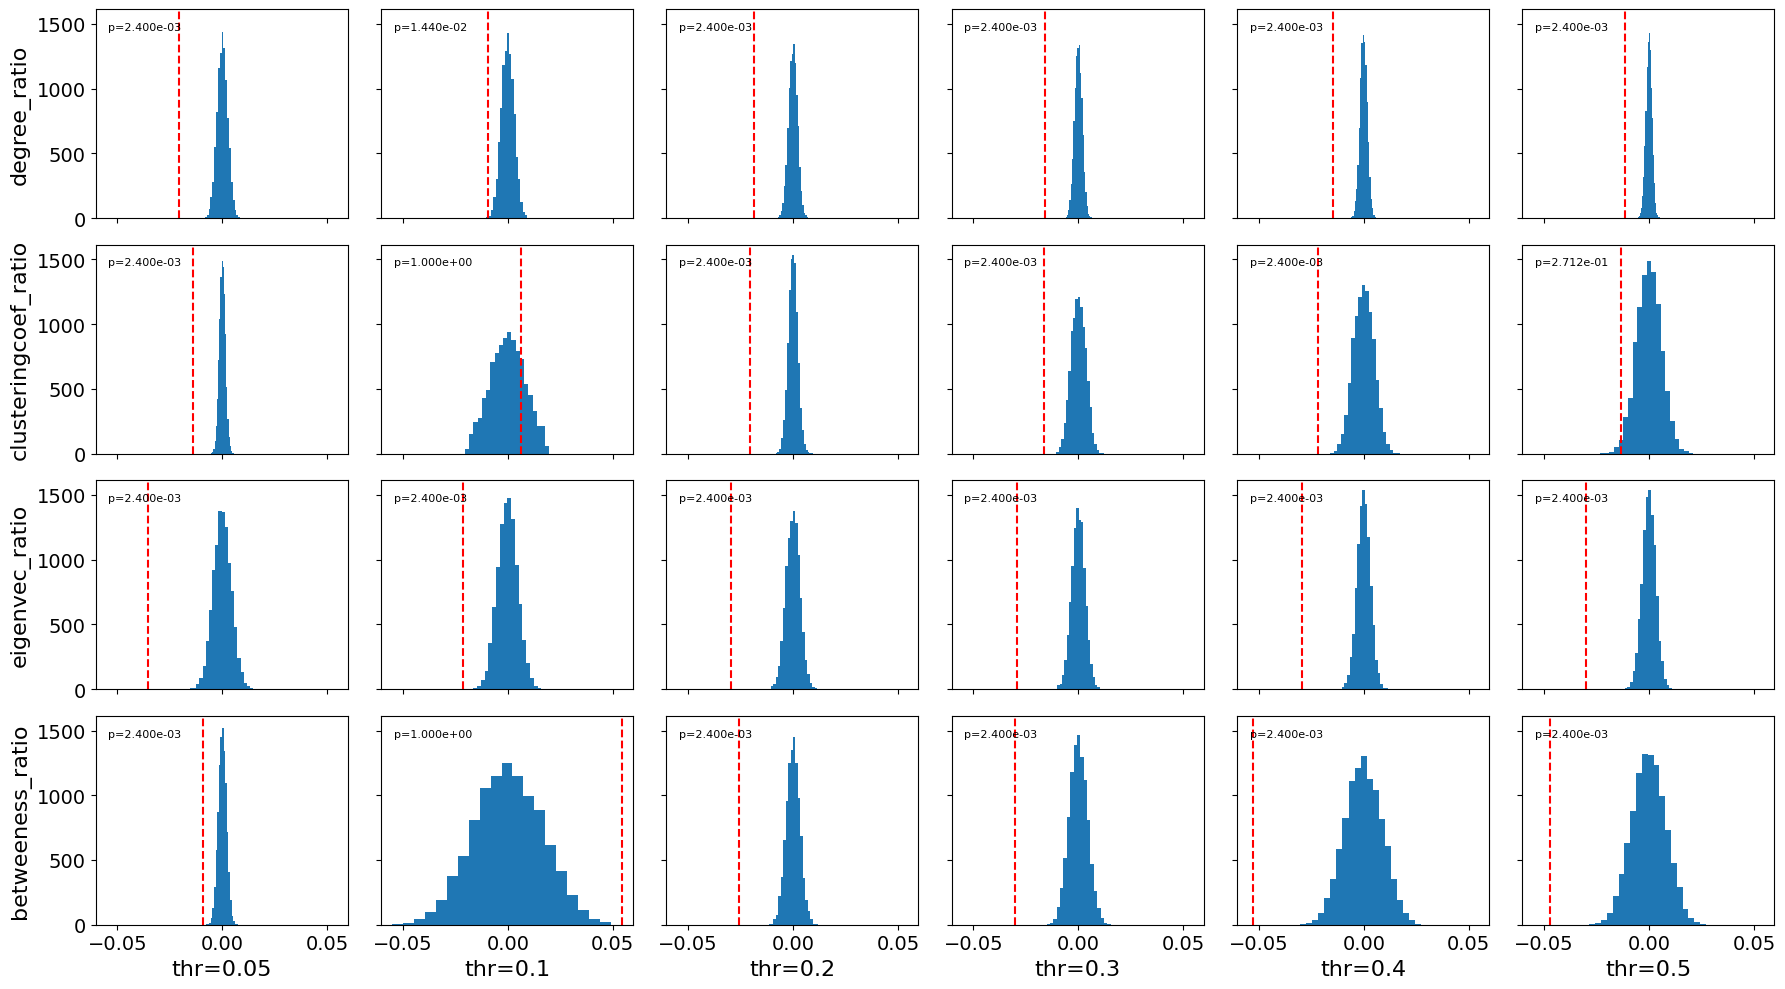

In [28]:
from statsmodels.stats.multitest import multipletests
import scipy.stats
from scipy.stats import permutation_test


metrics = ["degree_ratio","clusteringcoef_ratio","eigenvec_ratio","betweeness_ratio"]
thresholds = [0.05,0.1,0.2,0.3,0.4,0.5]
dataframes_pd = [diff_ratio05, diff_ratio1, diff_ratio2, diff_ratio3, diff_ratio4, diff_ratio5]

raw_pvals = []

# First loop: run tests and collect raw p-values
for df in dataframes_pd:
    for metric in metrics:
        data = df[metric].values
        # permutation test
        res = permutation_test(
            (data[0],),
            np.mean,
            permutation_type='samples',
            vectorized=True,
            alternative='less',
            random_state=1,
            axis=0
        )
        raw_pvals.append(res.pvalue)
# Apply Bonferroni correction
reject, pvals_bonf, _, _ = multipletests(raw_pvals, method='bonferroni')
pvals_bonf_matrix = pvals_bonf.reshape(len(dataframes_pd), len(metrics))
print(pvals_bonf_matrix)

# Second loop: plot
fig, axes = plt.subplots(len(metrics), len(thresholds),
                         figsize=(18, 10), sharex=True, sharey=True)

for i, metric in enumerate(metrics):
    for j, thr in enumerate(thresholds):
        ax = axes[i, j]
        df = dataframes_pd[j]
        data = df[metric].values
        
        # permutation test
        res = permutation_test(
            (data[0],),
            np.mean,
            permutation_type='samples',
            vectorized=True,
            alternative='less',
            random_state=1,
            axis=0
        )

        ax.hist(res.null_distribution, bins=20)
        ax.axvline(res.statistic, color='red', linestyle='--')

        # Add corrected p-value
        p_corr = pvals_bonf_matrix[j, i]
        ax.text(0.05, 0.9, f"p={p_corr:.3e}", transform=ax.transAxes, fontsize=8)

        # Set labels only on left column or bottom row
        if j == 0:
            ax.set_ylabel(metric)
        if i == len(metrics)-1:
            ax.set_xlabel(f"thr={thr}")

plt.tight_layout()
plt.show()


In [ ]:
# ---- Data ----
data_num_noconf = [avrg05_Wconf_num, avrg1_Wconf_num, avrg2_Wconf_num, avrg3_Wconf_num, avrg4_Wconf_num, avrg5_Wconf_num]
data_num_withconf = [Wavrg05_Wconf_num, Wavrg1_Wconf_num, Wavrg2_Wconf_num, Wavrg3_Wconf_num, Wavrg4_Wconf_num, Wavrg5_Wconf_num]

data_anat_noconf = [avrg05_Wconf_anat, avrg1_Wconf_anat, avrg2_Wconf_anat, avrg3_Wconf_anat, avrg4_Wconf_anat, avrg5_Wconf_anat]
data_anat_withconf = [Wavrg05_Wconf_anat, Wavrg1_Wconf_anat, Wavrg2_Wconf_anat, Wavrg3_Wconf_anat, Wavrg4_Wconf_anat, Wavrg5_Wconf_anat]


# Replace with your actual dfs
dataframes_num = [diff_num05, diff_num1, diff_num2, diff_num3, diff_num4, diff_num5 ]
dataframes_anat = [diff_anat05, diff_anat1, diff_anat2, diff_anat3, diff_anat4, diff_anat5 ]
dataframes_pd = [diff_ratio05, diff_ratio1, diff_ratio2, diff_ratio3, diff_ratio4, diff_ratio5 ]

In [41]:
ratio05

,degree_ratio,betweeness_ratio,eigenvec_ratio,clusteringcoef_ratio
0,"[0.09623278522195164, 0.08067775471439746, 0.0...","[0.04588238956854981, 0.04679901633172759, 0.0...","[0.11598210760902876, 0.10151828197321972, 0.1...","[0.03201666661560164, 0.03154160769013096, 0.0..."


In [43]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# RatioVar
Wratio = [Wratio05, Wratio1, Wratio2, Wratio3, Wratio4, Wratio5]
Nratio = [ratio05, ratio1, ratio2, ratio3, ratio4, ratio5]
metrics = ["degree_ratio","clusteringcoef_ratio","eigenvec_ratio","betweeness_ratio"]
thresholds = [0.05,0.1,0.2,0.3,0.4,0.5] 
# ---- Helper: Cohen's d for independent samples ----
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_sd = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pooled_sd

# ---- Helper: get column with metric substring ----
def get_metric_col(df, metric):
    col = next((c for c in df.columns if metric in c), None)
    if col is None:
        raise KeyError(f"No column containing '{metric}' found")
    return col

# ---- Run KS-test + Cohen's d ----
results = []

for metric in metrics:
    for t, df_num_nc, df_num_wc, df_anat_nc, df_anat_wc, df_rat_nc, df_rat_wc in zip(
        thresholds, data_num_noconf, data_num_withconf, data_anat_noconf, data_anat_withconf, Nratio, Wratio
    ):
        # col_num = get_metric_col(df_num_nc, metric)
        # col_anat = get_metric_col(df_anat_nc, metric)
        col_ratio = get_metric_col(df_rat_nc, metric)

    

        # RATIO comparison
        ratio_nc_vals = np.concatenate(df_rat_nc[col_ratio].values)
        ratio_wc_vals = np.concatenate(df_rat_wc[col_ratio].values)
        ks_stat_ratio, pval_ratio = ks_2samp(ratio_wc_vals, ratio_nc_vals)
        d_ratio = cohens_d(ratio_wc_vals,ratio_nc_vals)

        results.append({
            'Metric': metric,
            'Threshold': t,
            'Cohen_d_ratio': d_ratio
        })

# ---- Convert to DataFrame ----
results_df = pd.DataFrame(results)
results_df


,Metric,Threshold,Cohen_d_ratio
0,degree_ratio,0.05,1.506006
1,degree_ratio,0.10,0.464766
2,degree_ratio,0.20,1.991544
3,degree_ratio,0.30,1.464262
4,degree_ratio,0.40,1.464949
5,degree_ratio,0.50,1.155658
6,clusteringcoef_ratio,0.05,5.049760
7,clusteringcoef_ratio,0.10,-0.108607
8,clusteringcoef_ratio,0.20,2.341587
9,clusteringcoef_ratio,0.30,0.633077
